In [1]:
# imports

In [3]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 14
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
ONE_TIMES_ONE = (9,8)
TWO_TIMES_ONE = (20,8)
TWO_TIMES_TWO = (20,15)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THICK)

plt.rc('font', size=MEDIUM, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [31]:
class Sirs:
    def __init__(self, N0, I0, fa=(lambda t: 4), b=2, c=.5, d=0, dI=0, e=0, f=(lambda t: 0)):
        self.N = N0
        self.S = N0 - I0
        self.I = I0
        self.R = 0
        self.fa = fa
        self.b = b
        self.c = c
        self.d = d
        self.dI = dI
        self.e = e
        self.f = f
        
    def S_dot(self, ti, Si):
        return self.c*self.R - self.fa(ti)*Si*self.I/self.N - self.d*Si + self.e*self.N - self.f(ti)
    
    def I_dot(self, ti, Ii):
        return self.fa(ti)*self.S*Ii/self.N - (self.b + self.d + self.dI)*Ii
    
    def R_dot(self, ti, Ri):
        return self.b*self.I - (self.c + self.d)*Ri + self.f(ti)
    
    def N_dot(self, ti, Ni):
        return self.e*Ni - self.d*self.N - self.dI*self.I
    
    def delta_t(self, ti=0):
        a = self.fa(ti)
        return min(4/(a*self.N), 1/(self.b*self.N), 1/(self.c*self.N), 
                   1/(self.e) if self.e else 1, 
                   1/(self.d*self.N) if self.d else 1, 
                   1/(self.dI*self.N) if self.dI else 1)
    
    def sir_transitions(self, random_number, dt, ti=0):
        si = 1 if random_number < (a*self.S*self.I/self.N)*dt else 0  # S -> I
        ir = 1 if random_number < (self.b*self.I)*dt else 0           # I -> R
        rs = 1 if random_number < (self.c*self.R)*dt else 0           # R -> S
        return (si, ir, rs)
    
    def vitality_transitions(self, random_number, dt):
        bs = 1 if random_number < (self.e*self.N)*dt else 0           # born -> S
        sd = 1 if random_number < (self.d*self.S)*dt else 0           # S -> dead
        idI = 1 if random_number < (self.dI*self.I)*dt else 0         # I -> dead disease
        idD = 1 if random_number < (self.d*self.I)*dt else 0          # I -> dead other cause
        rd = 1 if random_number < (self.d*self.R)*dt else 0           # s -> dead
        return (bs, sd, idI, idD, rd)
        
    def update(self, new_vals):
        S, I, R, N = new_vals
        self.S = S
        self.I = I
        self.R = R
        self.N = N
        
    def fractions(self):
        a = self.fa(0)
        s = self.b/a
        i = (1 - self.b/a)/(1 + self.b/self.c)
        r = 1 - s - i
        return (s, i, r)

In [32]:
class SirsSolver:
    def __init__(self, sirs):
        self.sirs = sirs
        self.fs = {'S':sirs.S_dot, 'I':sirs.I_dot, 'R':sirs.R_dot, 'N':sirs.N_dot}
        self.res = {'S':None, 'I':None, 'R':None, 'N':None}
        self.t = self.h = None

    def get_fractions(self):
        N = self.res['N']
        return (self.res['S']/N, self.res['I']/N, self.res['R']/N)
        
    def _init_run(self, n_iter):
        self.res['S'] = np.ndarray(n_iter)
        self.res['I'] = np.ndarray(n_iter)
        self.res['R'] = np.ndarray(n_iter)
        self.res['N'] = np.ndarray(n_iter)
        self.res['S'][0] = self.sirs.S
        self.res['I'][0] = self.sirs.I
        self.res['R'][0] = self.sirs.R
        self.res['N'][0] = self.sirs.N
    
    def _rk4(self, code, i):
        f = self.fs[code]
        yi = self.res[code][i-1]
        ti = self.t[i]
        h = self.h
        
        k1 = h*f(ti, yi)
        k2 = h*f(ti+.5*h, yi+.5*k1)
        k3 = h*f(ti+.5*h, yi+.5*k2)
        k4 = h*f(ti+h, yi+k3)
        
        return max(0, yi + (k1 + 2*k2 + 2*k3 + k4)/6)

    def run_rk4(self, t_max=20, n_iter=1000):
        self._init_run(n_iter+1)
        self.t = np.linspace(0, t_max, n_iter+1)
        self.h = t_max/n_iter
        for i in range(1, n_iter+1):
            self.res['S'][i] = self._rk4('S', i)
            self.res['I'][i] = self._rk4('I', i)
            self.res['N'][i] = self._rk4('N', i)
            self.res['R'][i] = self.res['N'][i] - self.res['S'][i] - self.res['I'][i]
            new_vals = (self.res['S'][i], self.res['I'][i], self.res['R'][i], self.res['N'][i])
            self.sirs.update(new_vals)
    

    def run_mc(self, t_max=20, n_iter=1000, seed=0):
        self._init_run(n_iter)
        self.t = np.ndarray(n_iter)
        self.t[0] = ti = 0
        np.random.seed(seed)
        random_numbers = np.random.rand(n_iter)
        i = 1
        while ti <= t_max:
            if i%n_iter == 0:
                random_numbers = np.random.rand(n_iter)
                self.t.resize(i+n_iter, refcheck=False)
                self.res['S'].resize(i+n_iter, refcheck=False)
                self.res['I'].resize(i+n_iter, refcheck=False)
                self.res['R'].resize(i+n_iter, refcheck=False)
                self.res['N'].resize(i+n_iter, refcheck=False)
            
            random_number = random_numbers[i%n_iter]
            dt = self.sirs.delta_t(ti)
            ti = self.t[i-1] + dt
            si, ir, rs = self.sirs.sir_transitions(random_number, dt, ti=ti)
            bs, sd, idI, idD, rd = self.sirs.vitality_transitions(random_number, dt)
            self.t[i] = ti
            self.res['S'][i] = self.res['S'][i-1] - si + rs + bs - sd
            self.res['I'][i] = self.res['I'][i-1] + si - ir - idI - idD
            self.res['N'][i] = self.res['N'][i-1] + bs - sd - idI - idD - rd
            self.res['R'][i] = self.res['N'][i] - self.res['S'][i] - self.res['I'][i]
            new_vals = (self.res['S'][i], self.res['I'][i], self.res['R'][i], self.res['N'][i])
            self.sirs.update(new_vals)
            i += 1
        
        ## trim trailing zeros
        self.t = np.trim_zeros(self.t, trim='b')
        new_length = len(self.t)
        self.res['S'] = self.res['S'][:new_length]
        self.res['I'] = self.res['I'][:new_length]
        self.res['R'] = self.res['R'][:new_length]
        self.res['N'] = self.res['N'][:new_length]

1310.0


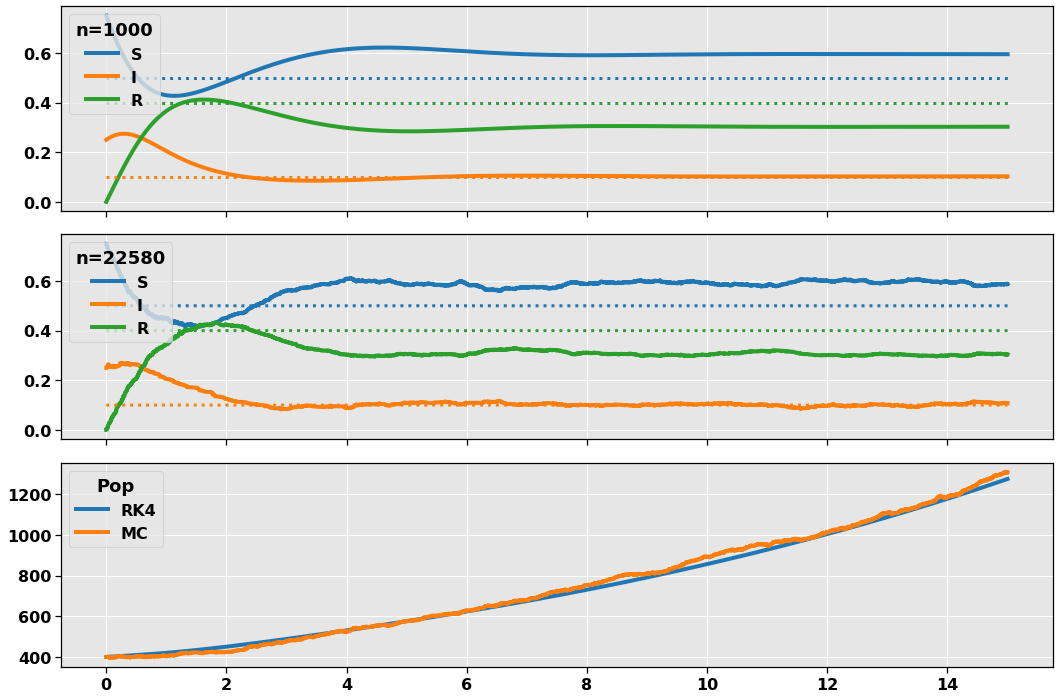

In [39]:
tn = 15

N0 = 400
I0 = 100
a = 4
b = 2
c = .5
e = .2
d = .1
dI = .2

#fa = (lambda t: 4 + 2*np.cos((2*np.pi/10)*(t)))
fa = (lambda t: a)
#f = (lambda t: .05 + .02*np.cos((2*np.pi/10)*(t)))
f = (lambda t: .0)

fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(15,10))

ax = axes[0]
n = 1000
sirs1 = Sirs(N0, I0, fa=fa, b=b, c=c, e=e, d=d, dI=dI, f=f)
solver1 = SirsSolver(sirs1)
solver1.run_rk4(tn, n)
S, I, R = solver1.get_fractions()

ax.plot(solver1.t, S)
ax.plot(solver1.t, I)
ax.plot(solver1.t, R)
ax.legend(['S', 'I', 'R'], title=f'n={n}', loc='upper left')
if True:
    s, i, r = sirs1.fractions()
    ax.plot(solver1.t, np.zeros(n+1) + s, ':', color=COLORS[0], lw=3)
    ax.plot(solver1.t, np.zeros(n+1) + i, ':', color=COLORS[1], lw=3)
    ax.plot(solver1.t, np.zeros(n+1) + r, ':', color=COLORS[2], lw=3)


ax = axes[1]
n = 1000
sirs2 = Sirs(N0, I0, fa=fa, b=b, c=c, e=e, d=d, dI=dI, f=f)
solver2 = SirsSolver(sirs2)
solver2.run_mc(tn, n, seed=5)
S, I, R = solver2.get_fractions()

nt = len(solver2.t)
ax.plot(solver2.t, S)
ax.plot(solver2.t, I)
ax.plot(solver2.t, R)
ax.legend(['S', 'I', 'R'], title=f'n={nt}', loc='upper left')
if True:
    s, i, r = sirs2.fractions()
    ax.plot(solver2.t, np.zeros(nt) + s, ':', color=COLORS[0], lw=3)
    ax.plot(solver2.t, np.zeros(nt) + i, ':', color=COLORS[1], lw=3)
    ax.plot(solver2.t, np.zeros(nt) + r, ':', color=COLORS[2], lw=3)


ax = axes[2]
ax.plot(solver1.t, solver1.res['N'])
ax.plot(solver2.t, solver2.res['N'])
ax.legend(['RK4', 'MC'], title=f'Pop', loc='upper left')
print(solver2.res['N'].max())

plt.tight_layout()
plt.show()

410.0